In [439]:
# Add these imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [440]:
# Load and explore data
df = pd.read_csv('https://raw.githubusercontent.com/SumanGouda/Machine-Learning-Projects/refs/heads/main/HEART%20DISEASE/heart_disease_uci.csv')

# Basic exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nTarget variable 'num' distribution:\n", df['num'].value_counts())

Dataset shape: (920, 16)

Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Data types:
 id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Target variable 'num' distribution:
 num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [441]:
df.columns 

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [442]:
df.drop(['id', 'dataset'], axis=1, inplace=True)

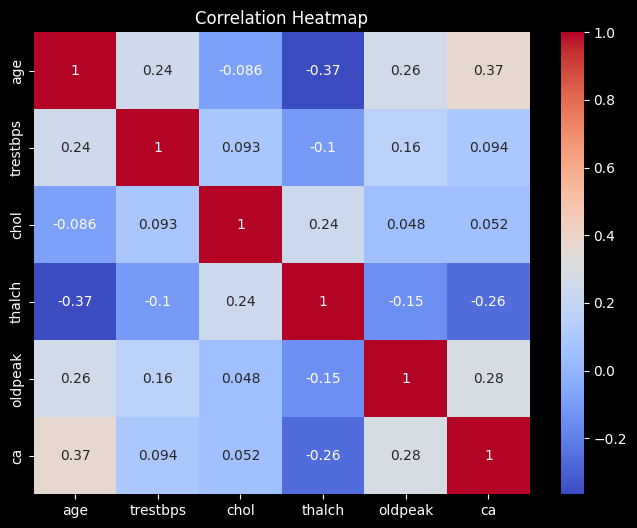

In [443]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Draw a corellation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# For dark theme 
plt.style.use('dark_background')
plt.show()

### <span style="color:cyan"><i>DATA CLEANING</i></span>

In [444]:
# Convert appropriate columns to proper data types
df['sex'] = df['sex'].astype('category')
df['cp'] = df['cp'].astype('category')
df['fbs'] = df['fbs'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['exang'] = df['exang'].astype('category')
df['slope'] = df['slope'].astype('category')
df['thal'] = df['thal'].astype('category')

In [445]:
# Handle outliers in numerical columns
def handle_outliers(df, columns):
    fig = make_subplots(rows=1, cols=len(columns), subplot_titles=[f"Box Plot of {col} (Before Outlier Removal)" for col in columns])
    for i, col in enumerate(columns):
        fig.add_trace(px.box(df, y=col).data[0], row=1, col=i+1)
        fig.update_xaxes(title_text=col, row=1, col=i+1)
    fig.update_layout(template='plotly_dark', width=500*len(columns), height=500)
    fig.show()
    return df

df = handle_outliers(df, numerical_cols)

In [446]:
# Filling all 'chol' with value 0 with np.nan
df.loc[df['chol'] == 0, 'chol'] = np.nan

#### <span style="color: yellow; font-weight: bold;">age</span>

In [447]:
df['age_range_simple'] = np.where(df['age'] < 40, '<40',
                         np.where(df['age'] < 50, '40-49',
                         np.where(df['age'] < 60, '50-59', '≥60')))

#### <span style="color: yellow; font-weight: bold;">trestbps</span>

In [448]:
# Handling the missing values
print(f'Number of missing values in trestbps: {df["trestbps"].isnull().sum()}\n')

missing_trestbps = df[df['trestbps'].isnull()]
missing_trestbps.head()

Number of missing values in trestbps: 59



,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_range_simple
393,48,Female,atypical angina,NaN,308.0,False,st-t abnormality,NaN,NaN,2.0,upsloping,NaN,NaN,0,40-49
599,35,Male,asymptomatic,NaN,NaN,NaN,normal,130.0,True,NaN,NaN,NaN,reversable defect,3,<40
714,69,Male,asymptomatic,NaN,NaN,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,reversable defect,3,≥60
733,63,Male,non-anginal,NaN,NaN,False,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,1,≥60
743,74,Male,non-anginal,NaN,NaN,False,normal,NaN,NaN,NaN,NaN,NaN,NaN,0,≥60


##### Observation :
Fill missing resting blood pressure values using age, cholesterol, maximum heart rate, and heart disease severity as key predictors. Apply Random Forest regression to estimate plausible values based on patients with similar physiological characteristics and medical conditions.

In [449]:
from sklearn.ensemble import RandomForestRegressor

In [450]:
def fill_trestbps_regression(df):
    """Use machine learning to predict missing BP values"""
    df_filled = df[['age', 'chol', 'thalch', 'oldpeak', 'num', 'sex', 'cp', 'fbs', 'trestbps']].copy()
    
    # Separate data with and without BP values
    known_bp = df_filled[df_filled['trestbps'].notnull()]
    unknown_bp = df_filled[df_filled['trestbps'].isnull()]
    
    if len(unknown_bp) == 0:
        return df_filled
    
    # Feature selection for BP prediction
    features = ['age', 'chol', 'thalch', 'oldpeak', 'num', 'sex', 'cp', 'fbs']
    
    # Prepare training data
    X_train = known_bp[features].copy()
    y_train = known_bp['trestbps']
    
    # Handle categorical variables
    categorical_features = ['sex', 'cp', 'fbs']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_bp[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['trestbps'].isnull(), 'trestbps'] = predictions
    
    return df_filled

df_regression = fill_trestbps_regression(df)

Before imputation: 59 missing values
After imputation: 0 missing values



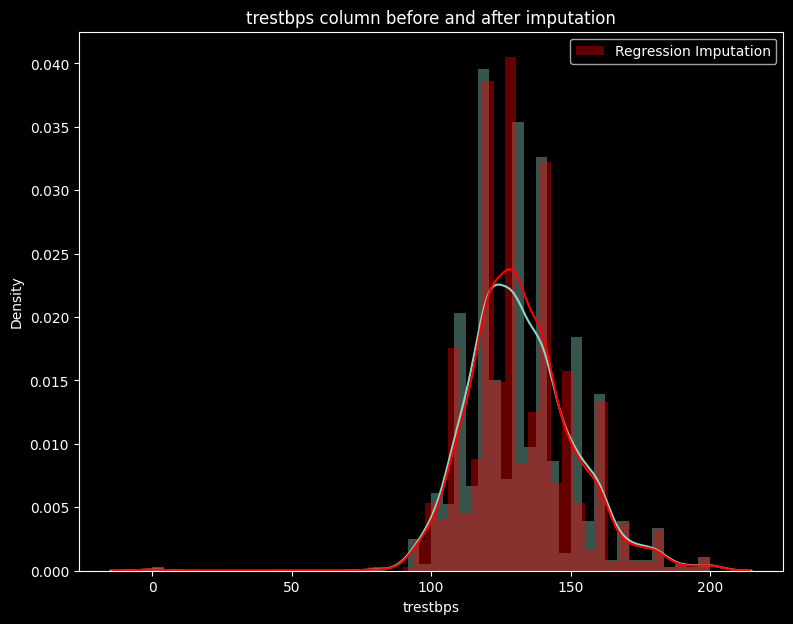

In [451]:
# Statistics of data before and after imputation
print(f'Before imputation: {df["trestbps"].isnull().sum()} missing values\nAfter imputation: {df_regression["trestbps"].isnull().sum()} missing values\n') 

# Analysisng data after imputation 
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.distplot(df['trestbps'])
sns.distplot(df_regression['trestbps'], color='red', label='Regression Imputation')
plt.title('trestbps column before and after imputation')

plt.legend()
plt.show()

In [452]:
# Filling up the the df['trestbps'] with the regression imputed values
df['trestbps'] = df_regression['trestbps']

In [453]:
def create_comprehensive_bp_features(df, bp_col='trestbps'):
    """
    Create balanced blood pressure feature representations
    """
    df_encoded = df[[bp_col]].copy()
    
    print(f"Original BP range: {df_encoded[bp_col].min()} - {df_encoded[bp_col].max()} mmHg")
    
    # 1. Simple risk level (0-3 scale)
    df_encoded['bp_risk_level'] = np.select(
        [
            df_encoded[bp_col] < 120,           # Normal
            (df_encoded[bp_col] >= 120) & (df_encoded[bp_col] < 140),  # Elevated/Stage1
            (df_encoded[bp_col] >= 140) & (df_encoded[bp_col] < 160),  # Stage2
            df_encoded[bp_col] >= 160           # Severe
        ],
        [0, 1, 2, 3],
        default=0
    )
    
    print("BP risk level distribution:")
    print(df_encoded['bp_risk_level'].value_counts().sort_index())
    
    return df_encoded

# Apply the function 
df_with_bp_features = create_comprehensive_bp_features(df)

Original BP range: 0.0 - 200.0 mmHg
BP risk level distribution:
bp_risk_level
0    164
1    433
2    230
3     93
Name: count, dtype: int64


In [454]:
# Since created features from the same BP data, just concatenate
bp_feature_columns = [col for col in df_with_bp_features.columns if col != 'trestbps']
df = pd.concat([df, df_with_bp_features[bp_feature_columns]], axis=1)
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_range_simple,bp_risk_level
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,≥60,2
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,≥60,3
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,≥60,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,<40,1
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,40-49,1


In [455]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'age_range_simple',
       'bp_risk_level'],
      dtype='object')

#### <span style="color: yellow; font-weight: bold;">chol</span>

In [456]:
# Filled all the 0 values with np.nan earlier 
print(f'Number of missing rows in the "chol" column: {df["chol"].isnull().sum()}')

df['chol'].describe()

Number of missing rows in the "chol" column: 202


count    718.000000
mean     246.832869
std       58.527062
min       85.000000
25%      210.000000
50%      239.500000
75%      276.750000
max      603.000000
Name: chol, dtype: float64

In [457]:
df_chol_missing = df[df['chol'].isnull()]
df_chol_missing.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_range_simple,bp_risk_level
305,29,Male,atypical angina,140.0,NaN,False,normal,170.0,False,0.0,NaN,NaN,NaN,0,<40,2
334,39,Male,atypical angina,120.0,NaN,False,st-t abnormality,146.0,False,2.0,upsloping,NaN,NaN,0,<40,1
337,39,Male,atypical angina,130.0,NaN,False,normal,120.0,False,0.0,NaN,NaN,NaN,0,<40,1
347,40,Male,non-anginal,140.0,NaN,False,normal,188.0,False,0.0,NaN,NaN,NaN,0,40-49,2
368,43,Female,non-anginal,150.0,NaN,False,normal,175.0,False,0.0,NaN,NaN,normal,0,40-49,2


**Age**: Cholesterol levels typically increase with age due to metabolic changes and cumulative lifestyle factors.

**trestbps**: High cholesterol often coexists with hypertension as both are cardiovascular risk factors that share common causes like poor diet and genetics.

**thalch**: Inverse relationship - patients with higher maximum heart rate capacity often have better cardiovascular health and lower cholesterol levels.

**num**: Direct correlation - higher heart disease severity strongly associates with elevated cholesterol due to atherosclerotic plaque formation.

**oldpeak**: Positive relationship - ST depression during exercise indicates cardiac stress, which correlates with higher cholesterol and arterial blockage.

In [458]:
def fill_chol_regression(df):   # Predicting the missing chol values using random forest
    """Use machine learning to predict missing cholesterol values"""
    df_filled = df[['age', 'trestbps', 'thalch', 'oldpeak', 'num', 'sex', 'cp', 'fbs', 'chol']].copy()
    
    # Separate data with and without cholesterol values
    known_chol = df_filled[df_filled['chol'].notnull()]
    unknown_chol = df_filled[df_filled['chol'].isnull()]
    
    if len(unknown_chol) == 0:
        return df_filled
    
    # Feature selection for cholesterol prediction
    features = ['age', 'trestbps', 'thalch', 'oldpeak', 'num', 'sex', 'cp', 'fbs']
    
    # Prepare training data
    X_train = known_chol[features].copy()
    y_train = known_chol['chol']
    
    # Handle categorical variables
    categorical_features = ['sex', 'cp', 'fbs']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_chol[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['chol'].isnull(), 'chol'] = predictions
    
    return df_filled

df_chol_filled = fill_chol_regression(df)


IMPUTATION SUMMARY:
Total records: 920
Records with missing cholesterol: 202
Records imputed: 0
Imputation successful: True


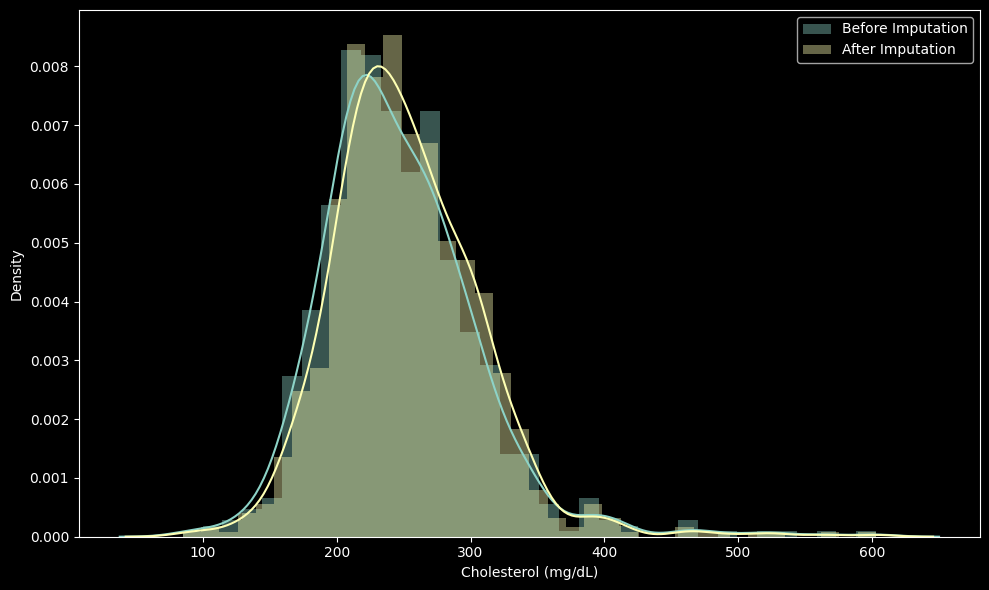

In [459]:
# Display results before and after cholesterol imputation
print("\n" + "=" * 50)
print("IMPUTATION SUMMARY:")
print("=" * 50)
print(f"Total records: {len(df)}")
print(f"Records with missing cholesterol: {df['chol'].isnull().sum()}")
print(f"Records imputed: {df_chol_filled['chol'].isnull().sum()}")
print(f"Imputation successful: {df_chol_filled['chol'].isnull().sum() == 0}")

# Plot the distribution of cholesterol before and after imputation
plt.figure(figsize=(10, 6))
sns.distplot(df['chol'], label='Before Imputation')
sns.distplot(df_chol_filled['chol'], label='After Imputation')
plt.xlabel('Cholesterol (mg/dL)')
plt.ylabel('Density')

plt.tight_layout()
plt.legend()

In [460]:
df['chol'] = df_chol_filled['chol']

In [461]:
def create_cholesterol_features(df, chol_col='chol'):
    """
    Create simple cholesterol risk feature
    """
    df_encoded = df[[chol_col]].copy()
    
    print(f"Original cholesterol range: {df_encoded[chol_col].min()} - {df_encoded[chol_col].max()} mg/dL")
    
    # Simple risk level (0-2 scale)
    df_encoded['chol_risk_level'] = np.select(
        [
            df_encoded[chol_col] < 200,           # Desirable
            (df_encoded[chol_col] >= 200) & (df_encoded[chol_col] < 240),  # Borderline
            df_encoded[chol_col] >= 240           # High
        ],
        [0, 1, 2],
        default=0
    )
    
    print("Cholesterol risk level distribution:")
    print(df_encoded['chol_risk_level'].value_counts().sort_index())
    
    return df_encoded

df_with_chol_features = create_cholesterol_features(df_chol_filled)

Original cholesterol range: 85.0 - 603.0 mg/dL
Cholesterol risk level distribution:
chol_risk_level
0    128
1    284
2    508
Name: count, dtype: int64


In [462]:
# Since created features from the same BP data, just concatenate
chol_feature_columns = [col for col in df_with_chol_features.columns if col != 'chol']
df = pd.concat([df, df_with_chol_features[chol_feature_columns]], axis=1)

#### <span style="color: yellow; font-weight: bold;">fbs</span>

In [463]:
df['fbs'].isna().sum()

np.int64(90)

In [464]:
# Making the categorical fbs column into numerical one 
df['fbs'] = df['fbs'].apply(lambda x: float(x) if pd.notna(x) else x)

In [465]:
def fill_fbs_regression(df):
    """Use machine learning to predict missing Fasting Blood Sugar values"""
    df_filled = df[['age', 'thalch', 'oldpeak', 'trestbps', 'chol', 'fbs']].copy()
    
    # Convert fbs to float first to avoid categorical issues
    df_filled['fbs'] = df_filled['fbs'].astype(float)
    
    # Separate data with and without fbs values
    known_fbs = df_filled[df_filled['fbs'].notnull()]
    unknown_fbs = df_filled[df_filled['fbs'].isnull()]
    
    if len(unknown_fbs) == 0:
        return df_filled
    
    # Feature selection for fbs prediction
    features = ['age', 'thalch', 'oldpeak', 'trestbps', 'chol']
    
    # Prepare training data
    X_train = known_fbs[features].copy()
    y_train = known_fbs['fbs']
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_fbs[features].copy()
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['fbs'].isnull(), 'fbs'] = predictions
    
    return df_filled

filled_fbs_df = fill_fbs_regression(df)

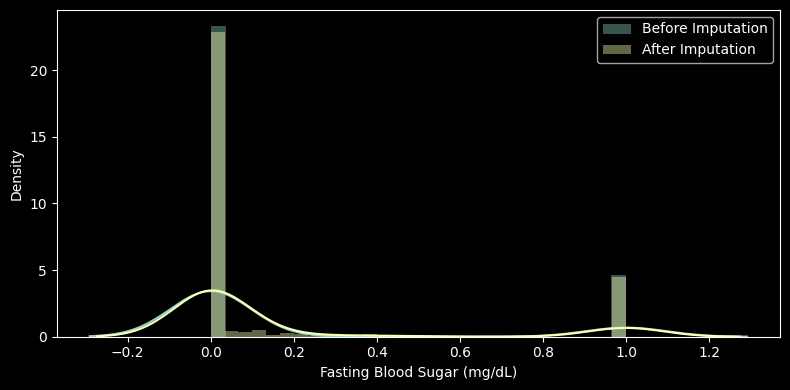

In [466]:
# Plot the distribution of fbs before and after imputation
plt.figure(figsize=(8, 4))
sns.distplot(df['fbs'], label='Before Imputation')
sns.distplot(filled_fbs_df['fbs'], label='After Imputation')
plt.xlabel('Fasting Blood Sugar (mg/dL)')
plt.ylabel('Density')

plt.tight_layout()
plt.legend()

In [467]:
# As the plot looks nearly simmilar so we would impute the results into the df['fbs'] column
df['fbs'] = filled_fbs_df['fbs']

#### <span style="color: yellow; font-weight: bold;">restecg</span>

In [468]:
df['restecg'].isna().sum()

np.int64(2)

In [469]:
# Only 2 values are missing so we can drop them
df.dropna(subset=['restecg'], inplace=True)

#### <span style="color: yellow; font-weight: bold;">thalch</span>

In [470]:
df['thalch'].isna().sum()

np.int64(55)

In [471]:
df['thalch'].describe()

count    863.000000
mean     137.528389
std       25.950226
min       60.000000
25%      120.000000
50%      140.000000
75%      157.000000
max      202.000000
Name: thalch, dtype: float64

In [472]:
# Check suspicious low values
low_thalch = df[df['thalch'] < 80]
print("Suspicious low thalch values:")
print(low_thalch[['age', 'thalch']])

# Check if low values correlate with health issues
print("\nPatients with thalch < 80:")
print(df[df['thalch'] < 80]['num'].value_counts())  # heart disease presence

Suspicious low thalch values:
     age  thalch
245   67    71.0
631   51    60.0
677   60    63.0
680   61    70.0
685   61    77.0
692   62    72.0
694   62    72.0
695   62    78.0
705   65    67.0
800   58    69.0
854   55    73.0

Patients with thalch < 80:
num
3    7
2    2
1    1
0    1
Name: count, dtype: int64


#### Conclusion: Not Data Errors!
**These are clinically valid values - patients with severe heart disease often have artificially suppressed heart rates due to medication.**

In [473]:
def fill_thalch_regression(df):
    """Use machine learning to predict missing thalach values"""
    df_filled = df[['exang', 'oldpeak', 'thalch']].copy()
    
    # Drop rows where any of our features (exang, oldpeak) are missing
    df_filled = df_filled.dropna(subset=['exang', 'oldpeak'])
    
    # Then proceed with your existing code
    known_thalch = df_filled[df_filled['thalch'].notnull()]
    unknown_thalch = df_filled[df_filled['thalch'].isnull()]
    
    if len(unknown_thalch) == 0:
        return df_filled
    
    features = ['age_range_simple', 'exang', 'oldpeak']
    
    X_train = known_thalch[features].copy()
    y_train = known_thalch['thalch']
    
    categorical_features = ['exang', 'age_range_simple']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    X_pred = unknown_thalch[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    df_filled.loc[df_filled['thalch'].isnull(), 'thalch'] = predictions
    
    return df_filled

df_regression = fill_thalch_regression(df)

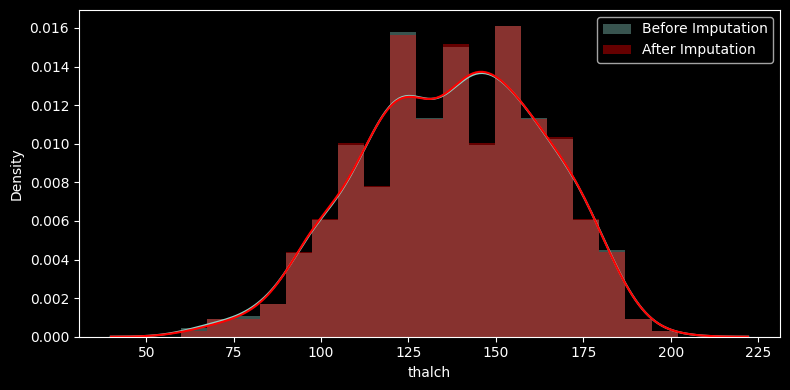

In [474]:
# Check the distribution of thalch before and after imputation
plt.figure(figsize=(8, 4))
sns.distplot(df['thalch'], label='Before Imputation')
sns.distplot(df_regression['thalch'], label='After Imputation', color='red')
plt.xlabel('thalch')
plt.ylabel('Density')

plt.tight_layout()
plt.legend()

#### <span style="color: yellow; font-weight: bold;">exang</span>

In [475]:
df['exang'].isna().sum()

np.int64(55)

In [476]:
# Making the categorical exang column into numerical one 
df['exang'] = df['exang'].apply(lambda x: float(x) if pd.notna(x) else x)

In [477]:
def fill_exang_regression(df):
    df_filled = df[['exang', 'cp', 'oldpeak', 'thalch']].copy()
    
    # Drop rows where any of our features are missing
    df_filled = df_filled.dropna(subset=['cp', 'oldpeak', 'thalch'])
    
    # Separate data with and without exang values
    known_exang = df_filled[df_filled['exang'].notnull()]
    unknown_exang = df_filled[df_filled['exang'].isnull()]
    
    if len(unknown_exang) == 0:
        return df_filled
    
    # Feature selection for exang prediction
    features = ['cp', 'oldpeak', 'thalch']
    
    # Prepare training data
    X_train = known_exang[features].copy()
    y_train = known_exang['exang']
    
    # Handle categorical variables
    categorical_features = ['cp']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_exang[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    
    # Fill missing values (convert to int for boolean)
    df_filled.loc[df_filled['exang'].isnull(), 'exang'] = predictions.round().astype(int)
    
    return df_filled

df_filled_exang = fill_exang_regression(df)

In [478]:
# Check for before and after imputation
print(f'Missing values in exang column before imputation: {df["exang"].isna().sum()}')
print(f'Missing values in exang column after imputation: {df_filled_exang["exang"].isna().sum()}')

# Number of each value in the exang column before and after imputation
print("Before Imputation:")
print(df['exang'].value_counts())
print("After Imputation:")
print(df_filled_exang['exang'].value_counts())

Missing values in exang column before imputation: 55
Missing values in exang column after imputation: 0
Before Imputation:
exang
0.0    526
1.0    337
Name: count, dtype: int64
After Imputation:
exang
0.0    522
1.0    333
Name: count, dtype: int64


In [479]:
# As the plot is almost similar so we would impute the results into the df['thalch'] column
df['thalch'] = df_regression['thalch']

#### <span style="color: yellow; font-weight: bold;">oldpeak</span>

In [480]:
df['oldpeak'].isna().sum()

np.int64(62)

In [481]:
df['oldpeak'].describe()

count    856.000000
mean       0.880607
std        1.091840
min       -2.600000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: oldpeak, dtype: float64

In [482]:
# Check rows with negative oldpeak
negative_oldpeak = df[df['oldpeak'] < 0]
print("Rows with negative oldpeak (data errors):")
print(negative_oldpeak[['oldpeak', 'age', 'num']])

Rows with negative oldpeak (data errors):
     oldpeak  age  num
603     -1.1   38    0
609     -1.5   42    1
614     -0.1   45    0
615     -2.6   46    1
629     -0.7   51    2
653     -2.0   56    2
655     -1.0   56    1
656     -1.0   56    2
691     -0.8   62    1
694     -0.5   62    1
696     -0.9   63    1
725     -0.5   66    0


<span style="color: yellow; font-style: italic;">These negative oldpeak values are data entry errors</span>

In [483]:
# Convert negative values to positive (absolute value)
df['oldpeak'] = df['oldpeak'].abs()

# Or set them to 0 (since ST depression can't be negative)
df['oldpeak'] = df['oldpeak'].clip(lower=0)

# Or treat them as missing values and impute
df.loc[df['oldpeak'] < 0, 'oldpeak'] = np.nan

In [484]:
def fill_oldpeak_regression(df):
    """Use machine learning to predict missing oldpeak values"""
    df_filled = df[['exang', 'thalch', 'cp', 'oldpeak']].copy()
    
    # Drop rows where any of our important features are missing
    df_filled = df_filled.dropna(subset=['exang', 'thalch', 'cp'])
    
    # Separate data with and without oldpeak values
    known_oldpeak = df_filled[df_filled['oldpeak'].notnull()]
    unknown_oldpeak = df_filled[df_filled['oldpeak'].isnull()]
    
    if len(unknown_oldpeak) == 0:
        return df_filled
    
    # Feature selection for oldpeak prediction - using important columns
    features = ['exang', 'thalch', 'cp']  # Most important predictors
    
    # Prepare training data
    X_train = known_oldpeak[features].copy()
    y_train = known_oldpeak['oldpeak']
    
    # Handle categorical variables
    categorical_features = ['exang', 'cp']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_oldpeak[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['oldpeak'].isnull(), 'oldpeak'] = predictions
    
    return df_filled

df_filled_oldpeak = fill_oldpeak_regression(df_filled_exang)

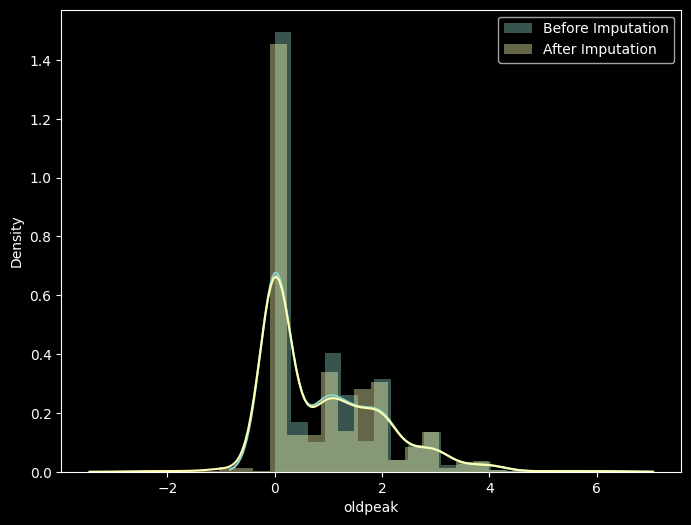

In [485]:
# Check for before and after imputation
plt.figure(figsize=(8, 6))

sns.distplot(df['oldpeak'], label='Before Imputation')
sns.distplot(df_filled_oldpeak['oldpeak'], label='After Imputation')
plt.xlabel('oldpeak')
plt.ylabel('Density')
plt.legend()

plt.show()

**As the imputation does not seems to be changing much trend in the datset column so we would stick to it**

In [486]:
df['oldpeak'] = df_filled_oldpeak['oldpeak']    

#### <span style="color: yellow; font-weight: bold;">slope</span>

In [487]:
df['slope'].isna().sum()    

np.int64(308)

In [488]:
df['slope'].value_counts()

slope
flat           345
upsloping      202
downsloping     63
Name: count, dtype: int64

In [489]:
# Applying the label encoding over the categorical slope columns 
df['slope'] = df['slope'].apply(lambda x: 0 if x == 'upsloping' else 1 if x == 'flat' else 2 if x == 'downsloping' else x)

In [490]:
df['slope'].astype('float64').dtypes

dtype('float64')

In [491]:
def fill_slope_classification(df):
    df_filled = df.copy()
    
    # Drop rows where key features are missing
    df_filled = df_filled.dropna(subset=['oldpeak', 'exang', 'cp', 'thalch', 'num', 'age'])
    
    # Separate data with and without slope values
    known_slope = df_filled[df_filled['slope'].notnull()]
    unknown_slope = df_filled[df_filled['slope'].isnull()]
    
    if len(unknown_slope) == 0:
        return df_filled
    
    # Enhanced feature selection for slope prediction
    features = [
        'oldpeak', 'exang', 'cp', 'thalch', 
        'num', 'age', 'trestbps', 'chol', 'fbs'
    ]
    
    # Prepare training data
    X_train = known_slope[features].copy()
    y_train = known_slope['slope'].astype(int)
    
    # Handle categorical variables
    categorical_features = ['exang', 'cp', 'fbs']
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category').cat.codes
    
    # Use CLASSIFIER
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_slope[features].copy()
    for col in categorical_features:
        X_pred[col] = X_pred[col].astype('category').cat.codes
    
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['slope'].isnull(), 'slope'] = predictions.astype(int)
    
    return df_filled

df_filled_slope = fill_slope_classification(df)

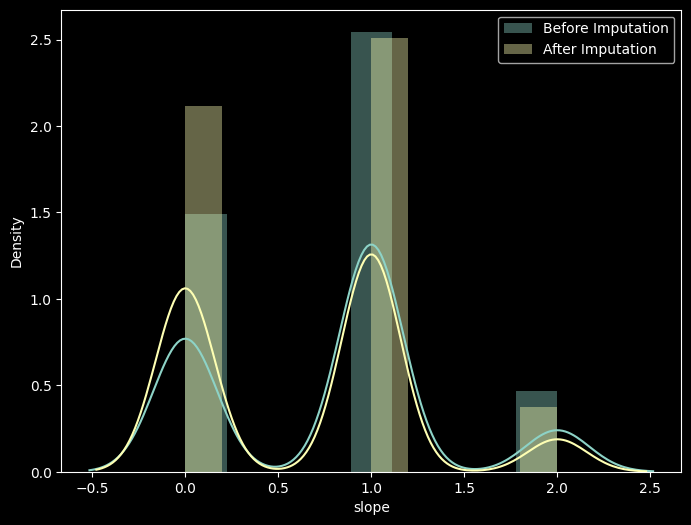

In [492]:
# Analysing before and after imputation
plt.figure(figsize=(8, 6))

sns.distplot(df['slope'], label='Before Imputation')
sns.distplot(df_filled_slope['slope'], label='After Imputation')
plt.xlabel('slope')
plt.ylabel('Density')
plt.legend()

plt.show()

**Tried many imputation techs but the imputation does not improved much**

In [493]:
df['slope'] = df_filled_slope['slope']

#### <span style="color: yellow; font-weight: bold;">ca</span>

In [494]:
df['ca'].isna().sum()

np.int64(609)

In [495]:
df['ca'].value_counts()

ca
0.0    181
1.0     67
2.0     41
3.0     20
Name: count, dtype: int64

In [496]:
def fill_ca_regression(df):
    df_filled = df.copy()
    
    # Drop rows where key features are missing
    df_filled = df_filled.dropna(subset=['num', 'oldpeak', 'thalch'])
    
    # Separate data with and without ca values
    known_ca = df_filled[df_filled['ca'].notnull()]
    unknown_ca = df_filled[df_filled['ca'].isnull()]
    
    if len(unknown_ca) == 0:
        return df_filled
    
    # Only the most important features
    features = ['num', 'oldpeak', 'thalch']
    
    # Prepare training data
    X_train = known_ca[features].copy()
    y_train = known_ca['ca']
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_ca[features].copy()
    predictions = model.predict(X_pred)
    
    # Fill missing values and round to integers (0,1,2,3)
    df_filled.loc[df_filled['ca'].isnull(), 'ca'] = predictions.round().astype(int)
    
    return df_filled

df_filled_ca = fill_ca_regression(df_filled_slope)

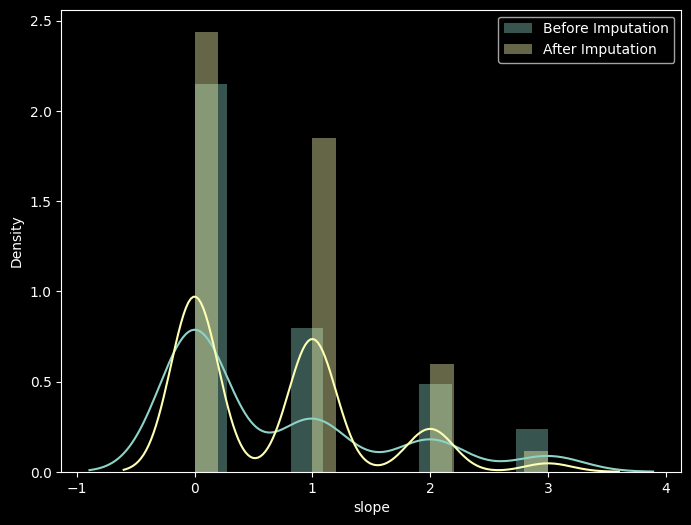

In [497]:
# Check for before and after imputation
# Analysing before and after imputation
plt.figure(figsize=(8, 6))

sns.distplot(df['ca'], label='Before Imputation')
sns.distplot(df_filled_ca['ca'], label='After Imputation')
plt.xlabel('slope')
plt.ylabel('Density')
plt.legend()

plt.show()

In [498]:
df['ca'] = df_filled_ca['ca']

#### <span style="color: yellow; font-weight: bold;">thal</span>

In [499]:
df['thal'].isna().sum() 

np.int64(484)

In [500]:
df['thal'].value_counts()

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64

In [501]:
# Making the categorical cols to numerical 
thal_mapping = {
    'normal': 0,              # Best - normal blood flow
    'reversable defect': 1,   # Intermediate - ischemia
    'fixed defect': 2         # Worst - heart muscle damage
}

df['thal'] = df['thal'].map(thal_mapping)
df['thal'].astype('float64').dtypes

dtype('float64')

In [502]:
from sklearn.ensemble import RandomForestClassifier

def fill_thal_regression(df):
    df_filled = df[['num', 'ca', 'oldpeak', 'thal']].copy()
    
    # Drop rows where key features are missing
    df_filled = df_filled.dropna(subset=['num', 'ca', 'oldpeak'])
    
    # Separate data with and without thal values
    known_thal = df_filled[df_filled['thal'].notnull()]
    unknown_thal = df_filled[df_filled['thal'].isnull()]
    
    if len(unknown_thal) == 0:
        return df_filled
    
    # Only the most important features
    features = ['num', 'ca', 'oldpeak']
    
    # Prepare training data
    X_train = known_thal[features].copy()
    y_train = known_thal['thal']
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_pred = unknown_thal[features].copy()
    predictions = model.predict(X_pred)
    
    # Fill missing values
    df_filled.loc[df_filled['thal'].isnull(), 'thal'] = predictions
    
    return df_filled

df_filled_thal = fill_thal_regression(df)

In [503]:
df_filled_thal['thal'].value_counts()

thal
0    416
1    383
2     56
Name: count, dtype: int64

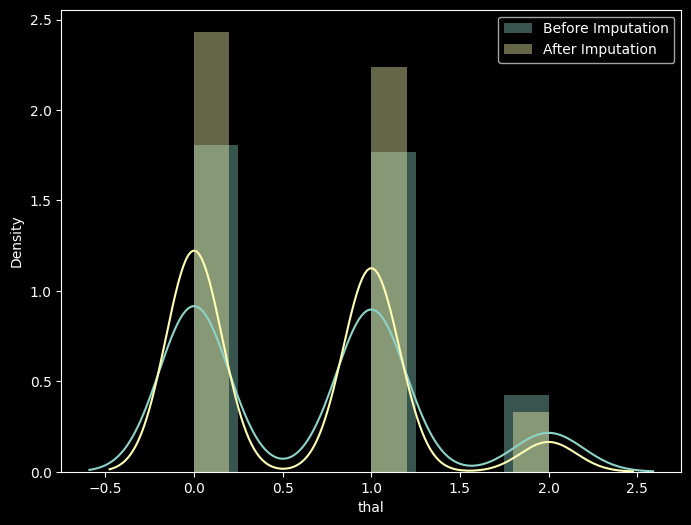

In [504]:
# Analysing before and after imputation
plt.figure(figsize=(8, 6))

sns.distplot(df['thal'], label='Before Imputation')
sns.distplot(df_filled_thal['thal'], label='After Imputation')
plt.xlabel('thal')
plt.ylabel('Density')
plt.legend()

plt.show()

**Now this is a well balanced imputation**

In [505]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,age_range_simple,bp_risk_level,chol_risk_level
0,63,Male,typical angina,145.0,233.0,1.0,lv hypertrophy,150.0,0.0,2.3,2,0.0,2,0,≥60,2,1
1,67,Male,asymptomatic,160.0,286.0,0.0,lv hypertrophy,108.0,1.0,1.5,1,3.0,0,2,≥60,3,2
2,67,Male,asymptomatic,120.0,229.0,0.0,lv hypertrophy,129.0,1.0,2.6,1,2.0,1,1,≥60,1,1
3,37,Male,non-anginal,130.0,250.0,0.0,normal,187.0,0.0,3.5,2,0.0,0,0,<40,1,2
4,41,Female,atypical angina,130.0,204.0,0.0,lv hypertrophy,172.0,0.0,1.4,0,0.0,0,0,40-49,1,1


### <span style="color:cyan"><i>EDA</i></span>

In [506]:
categorical_cols = []

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        categorical_cols.append(col)

categorical_cols

['sex', 'cp', 'restecg', 'exang', 'slope', 'thal', 'age_range_simple']

In [507]:
df['age_range_simple'].value_counts()

age_range_simple
50-59    374
≥60      253
40-49    212
<40       79
Name: count, dtype: int64

#### <span style="color: yellow; font-weight: bold;">age_range_simple</span>

In [508]:
age_mapping = {
    '<40': 0,
    '40-49': 1, 
    '50-59': 2,
    '≥60': 3
}

df['age_range_encoded'] = df['age_range_simple'].map(age_mapping)

#### <span style="color: yellow; font-weight: bold;">sex, cp</span>

In [509]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)  # Male = 1, Female = 0
df['cp'] = df['cp'].apply(lambda x: 1 if x == 'typical angina' else 2 if x == 'atypical angina' else 3 if x == 'non-anginal' else 4)


#### <span style="color: yellow; font-weight: bold;">rest_ecg</span>

In [510]:
# Check relationship between restecg and num (heart disease)

restecg_analysis = df.groupby('restecg')['num'].agg(['mean', 'count']).sort_values('mean')
print("Relationship between restecg and heart disease (num):")
print(restecg_analysis)
print("\n")

# Check if there's a clear ordinal pattern
if restecg_analysis['mean'].is_monotonic_increasing or restecg_analysis['mean'].is_monotonic_decreasing:
    print("✅ restecg appears to be ORDINAL - clear progression with heart disease")
else:
    print("❌ restecg appears to be NOMINAL - no clear progression with heart disease")

Relationship between restecg and heart disease (num):
                      mean  count
restecg                          
normal            0.838475    551
lv hypertrophy    1.164894    188
st-t abnormality  1.301676    179


✅ restecg appears to be ORDINAL - clear progression with heart disease


In [511]:
# Making it numerical 
df['restecg'] = df['restecg'].apply(lambda x: 1 if x == 'normal' else 2 if x == 'lv hypertrophy' else 3 if x == 'st-t abnormality' else x)

In [ ]:
# Keeping the non scaled data for the tree model 

non_scaled_df = df.copy()

### <span style="color:cyan"><i>Data Scaling</i></span>

In [512]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler

std_scaler = StandardScaler()
power_transform = PowerTransformer()
min_max = MinMaxScaler()

#### <span style="color: yellow; font-weight: bold;">age</span>

In [513]:
df['age'] = std_scaler.fit_transform(df['age'].values.reshape(-1, 1))

<Axes: xlabel='age', ylabel='Density'>

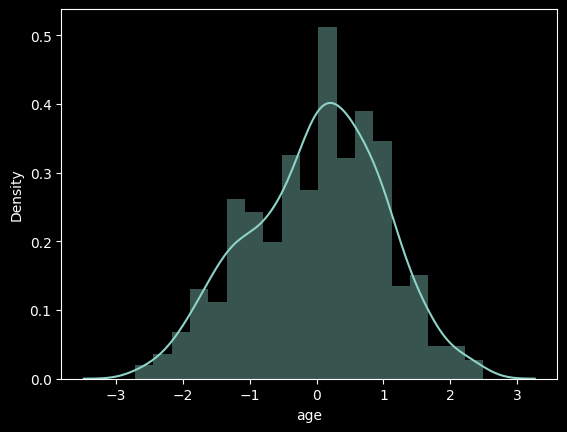

In [514]:
sns.distplot(df['age'])

#### <span style="color: yellow; font-weight: bold;">trestbps</span>

In [515]:
df['trestbps'].isnull().sum()

np.int64(0)

In [516]:
test_df = df['trestbps'].copy()

In [517]:
# Transform and assign directly
transformed_values = min_max.fit_transform(df['trestbps'].values.reshape(-1, 1)) 
test_df['trestbps'] = transformed_values.flatten()

In [518]:
test_df.isnull().sum()

np.int64(0)

<Axes: ylabel='Density'>

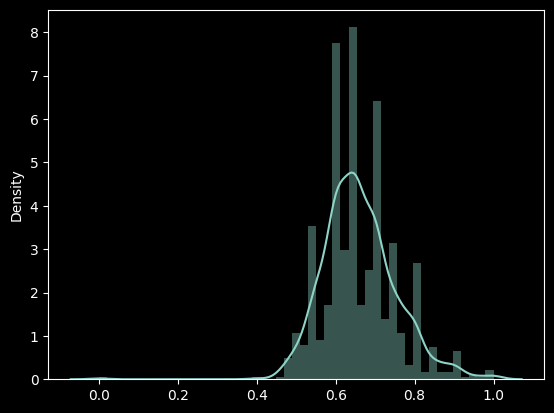

In [519]:
sns.distplot(test_df['trestbps'])

In [520]:
df['trestbps'] = test_df['trestbps']

In [521]:
df['trestbps'].isnull().sum()

np.int64(0)

<Axes: xlabel='trestbps', ylabel='Density'>

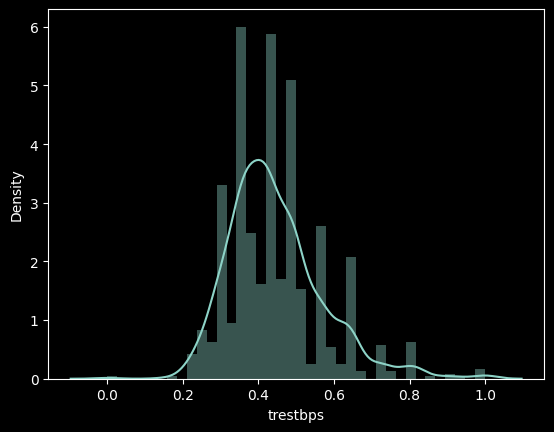

In [524]:
# As the data is left skewed data so we would make it little normal

sns.distplot(df['trestbps']**2)

In [525]:
df['trestbps'] = df['trestbps']**2

#### <span style="color: yellow; font-weight: bold;">chol</span>

In [526]:
test_df = df['chol'].copy()

<Axes: ylabel='Density'>

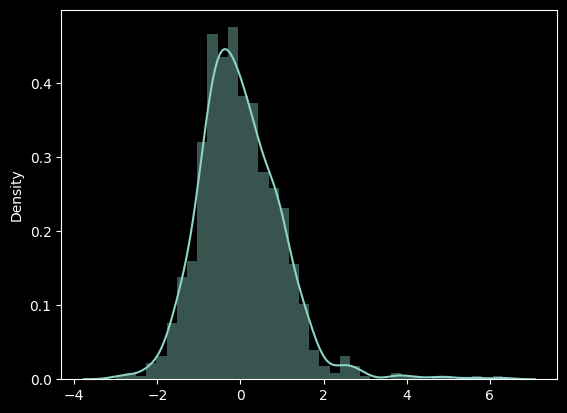

In [528]:
test_df['chol'] = std_scaler.fit_transform(df['chol'].values.reshape(-1, 1))

sns.distplot(test_df['chol'])

In [529]:
df['chol'] = test_df['chol']

#### <span style="color: yellow; font-weight: bold;">thalch</span>

In [530]:
test_df = df['thalch'].copy()

<Axes: ylabel='Density'>

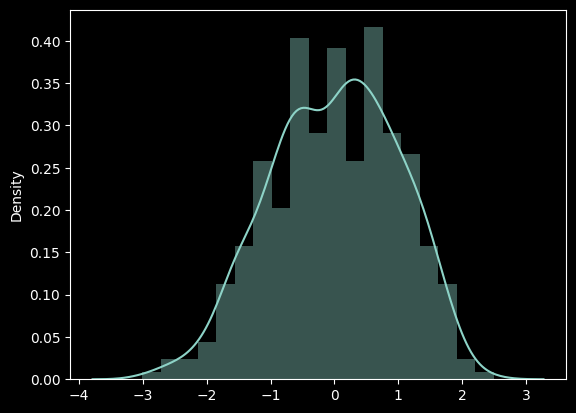

In [531]:
test_df['thalch'] = std_scaler.fit_transform(df['thalch'].values.reshape(-1, 1))

sns.distplot(test_df['thalch'])

In [532]:
df['thalch'] = test_df['thalch']

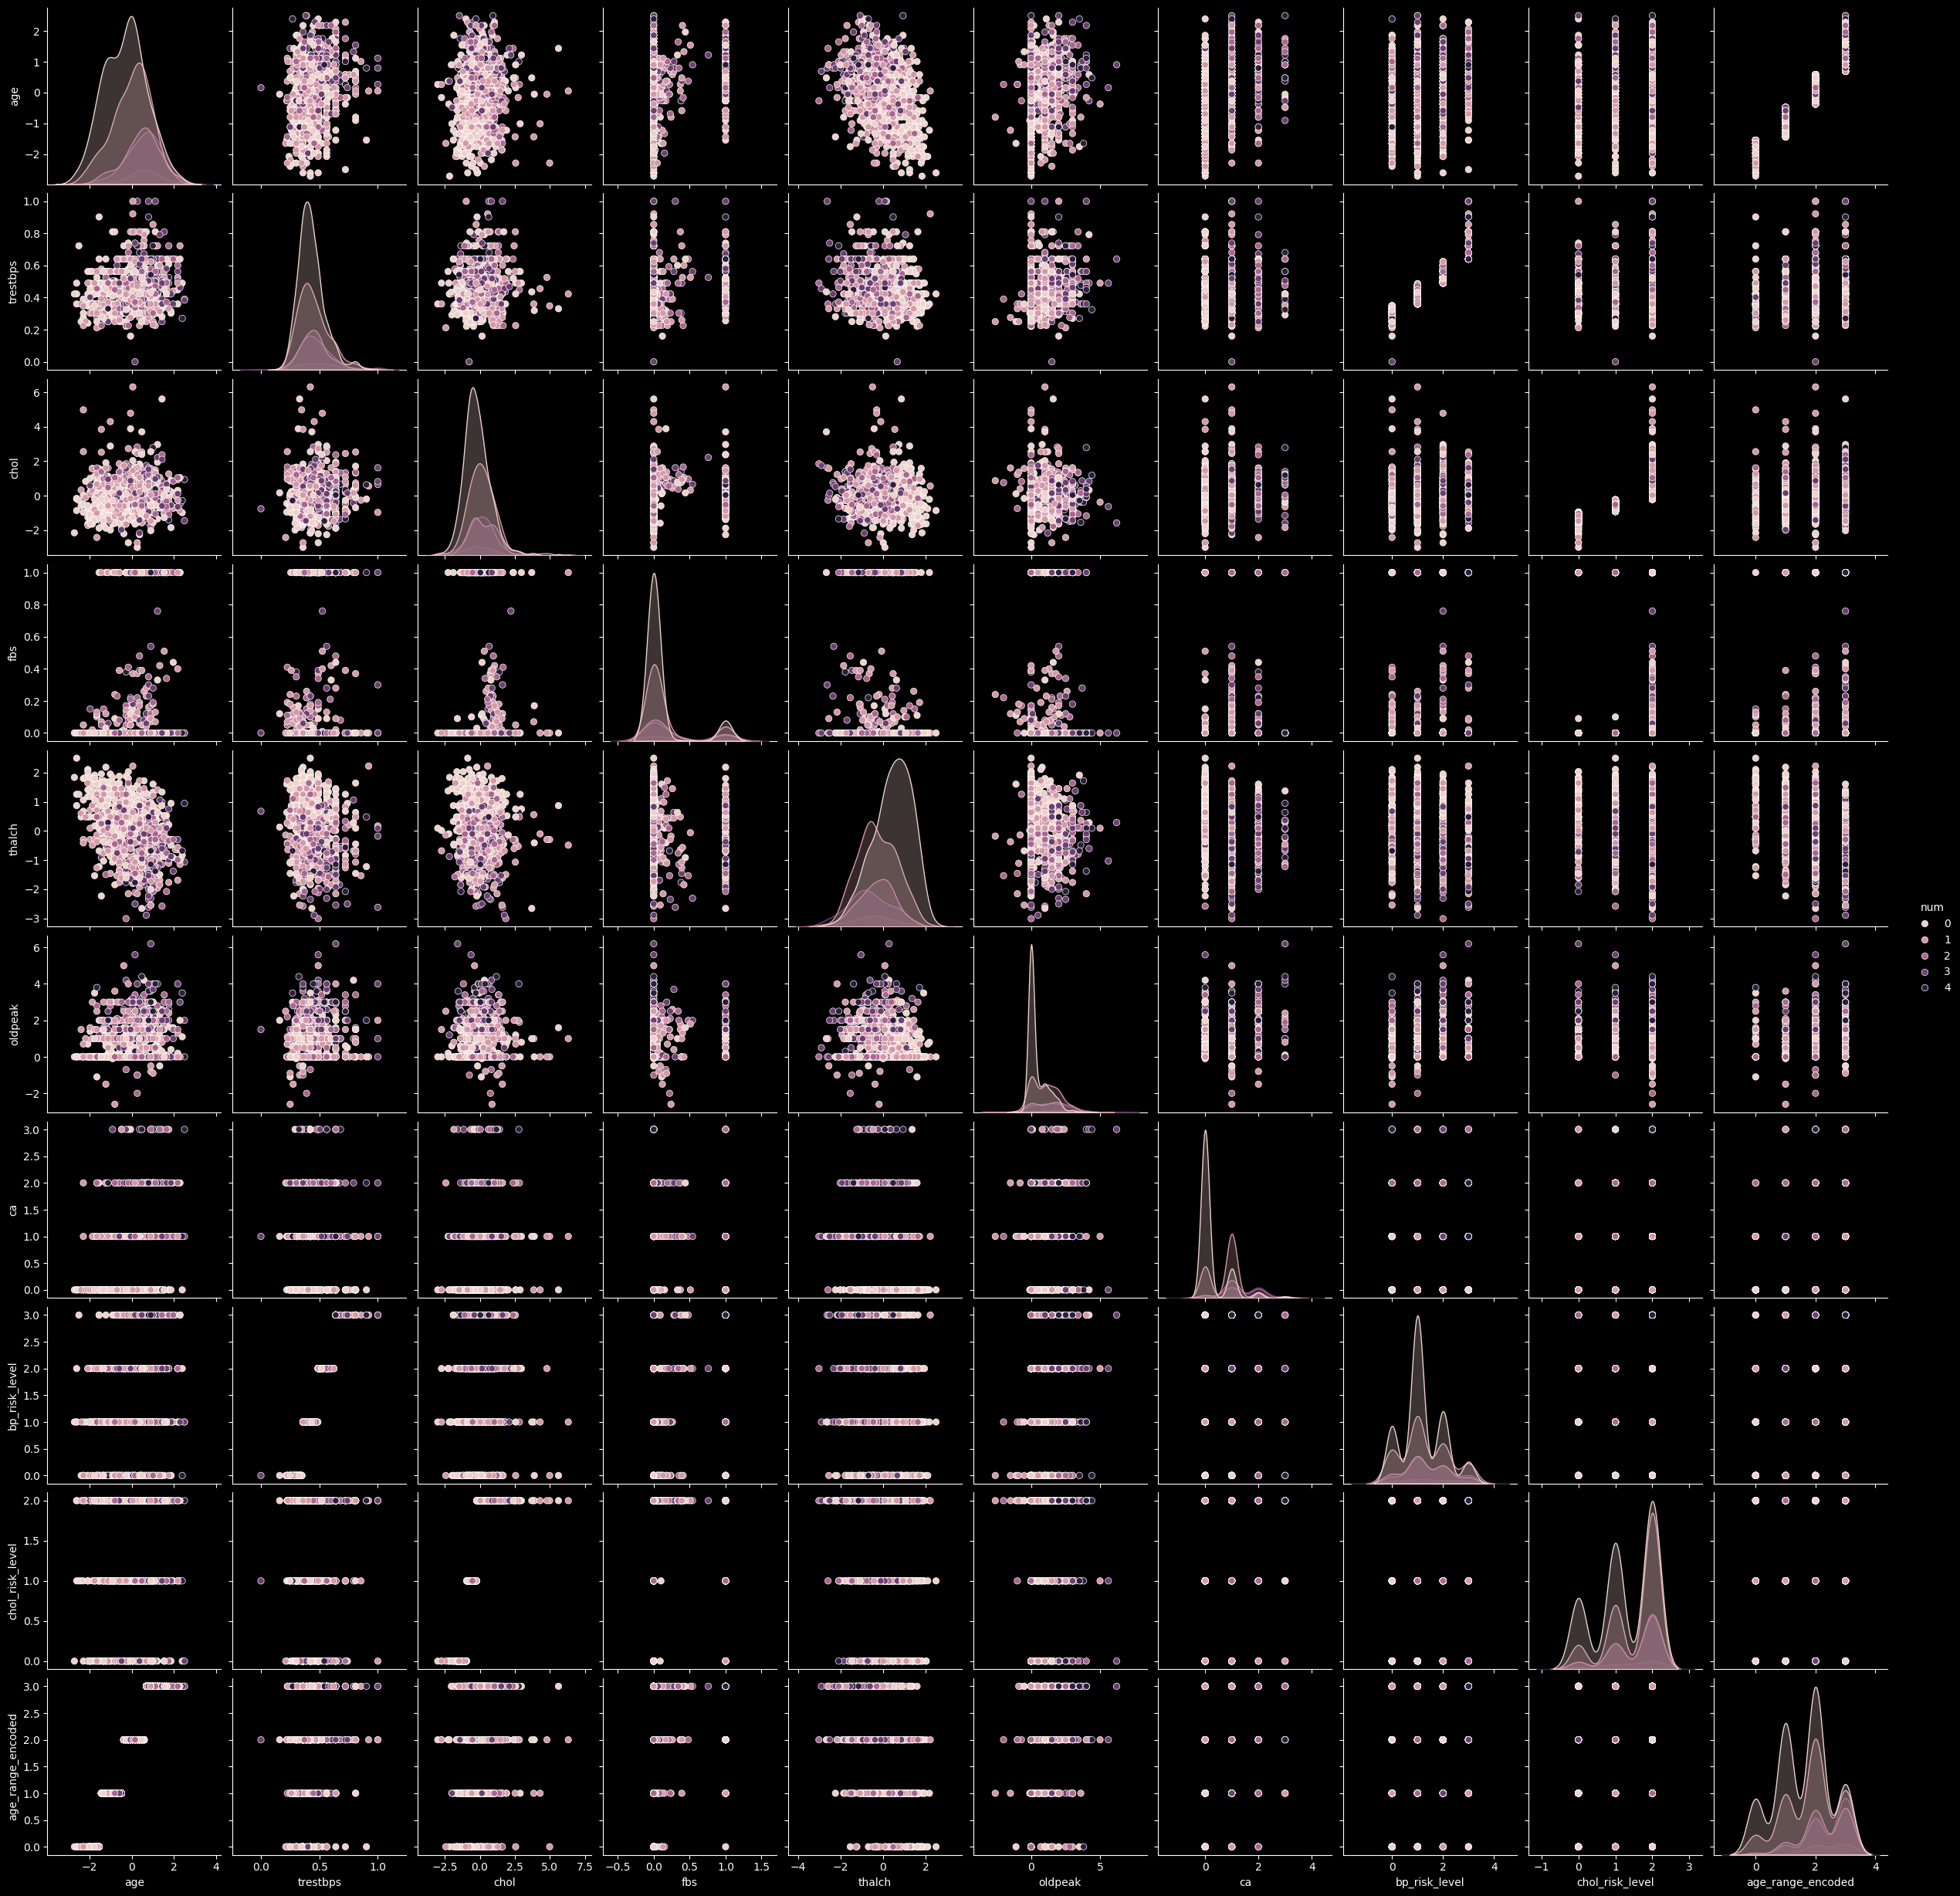

In [533]:
sns.pairplot(df, hue='num')

**Now we would apply the multinomial logistic regression over the dataset**

In [534]:
# Import the sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression

In [535]:
df['num'].value_counts()

num
0    411
1    263
2    109
3    107
4     28
Name: count, dtype: int64

In [536]:
df = pd.get_dummies(df, columns=['num'], drop_first=False, prefix='num')

In [541]:
# Make the boolean target values to numerical value
df['num_0'] = df['num_0'].astype('int')
df['num_1'] = df['num_1'].astype('int')
df['num_2'] = df['num_2'].astype('int')
df['num_3'] = df['num_3'].astype('int')
df['num_4'] = df['num_4'].astype('int')

In [553]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,...,thal,age_range_simple,bp_risk_level,chol_risk_level,age_range_encoded,num_0,num_1,num_2,num_3,num_4
0,1.006574,1,1,0.525625,-0.339657,1.0,2,0.479256,0.0,2.3,...,2,≥60,2,1,3,1,0,0,0,0
1,1.431759,1,4,0.640000,0.613219,0.0,2,-1.148330,1.0,1.5,...,0,≥60,3,2,3,0,0,1,0,0
2,1.431759,1,4,0.360000,-0.411573,0.0,2,-0.334537,1.0,2.6,...,1,≥60,1,1,3,0,1,0,0,0
3,-1.757133,1,3,0.422500,-0.034018,0.0,1,1.913082,0.0,3.5,...,0,<40,1,2,0,1,0,0,0,0
4,-1.331947,0,2,0.422500,-0.861043,0.0,2,1.331801,0.0,1.4,...,0,40-49,1,1,1,1,0,0,0,0


In [557]:
class Own_multinomial_logistic_regression():
    def __init__(self):
        pass
    
    def __split_dataset(self, y_train):
        """
        Split y_train into multiple target datasets
        Returns list of target columns only (no X features)
        """
        datasets = []
        
        # Get number of target columns from y_train shape
        if hasattr(y_train, 'shape'):
            n_targets = y_train.shape[1] if len(y_train.shape) > 1 else 1
        else:
            n_targets = 1
        
        for i in range(n_targets):
            # Get the i-th target column from y_train
            if n_targets > 1:
                if hasattr(y_train, 'iloc'):  # pandas DataFrame/Series
                    target_col = y_train.iloc[:, i]
                else:  # numpy array
                    target_col = y_train[:, i]
            else:
                target_col = y_train  # Single target
                
            datasets.append(target_col)
        
        return datasets
        
    def fit(self, X, y):
        y_0, y_1, y_2, y_3, y_4 = self.__split_dataset(y)
        return y_3
    
reg = Own_multinomial_logistic_regression()
reg.fit(df.iloc[:, :-5], df.iloc[:, -5:])
        
        

0      0
1      0
2      0
3      0
4      0
      ..
915    0
916    0
917    0
918    0
919    0
Name: num_3, Length: 918, dtype: int64